<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Распределение-игроков-по-классам-и-расам-персонажей" data-toc-modified-id="Распределение-игроков-по-классам-и-расам-персонажей-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Распределение игроков по классам и расам персонажей</a></span></li><li><span><a href="#ТОП-10-игровых-локаций" data-toc-modified-id="ТОП-10-игровых-локаций-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ТОП-10 игровых локаций</a></span></li><li><span><a href="#Динамика-базы-игроков" data-toc-modified-id="Динамика-базы-игроков-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Динамика базы игроков</a></span></li><li><span><a href="#Затраченное-на-развитие-персонажа-время" data-toc-modified-id="Затраченное-на-развитие-персонажа-время-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Затраченное на развитие персонажа время</a></span></li><li><span><a href="#Игровая-активность" data-toc-modified-id="Игровая-активность-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Игровая активность</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Анализ игровых метрик на примере World of Warcraft

Целью данного исследования является анализ поведения игроков и основных показателей, характеризующих динамику базы игроков.  
Источник данных для анализа - открытые данные по игре World of Warcraft с сайта https://www.kaggle.com/datasets/mylesoneill/warcraft-avatar-history
 
## Предобработка данных

Импортируем библиотеки:

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
from numpy import median
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import time
import july
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Прочитаем файл `wowah_data.csv` и сохраним его в переменной df. Выведем на экран первые 5 строк таблицы:

In [2]:
df = pd.read_csv('D:\Datasets\WoW\wowah_data.csv')
display(df.head())

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


Изучим общую информацию о таблице:

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   char        int64 
 1    level      int64 
 2    race       object
 3    charclass  object
 4    zone       object
 5    guild      int64 
 6    timestamp  object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


В анализируемой таблице 7 столбцов и 10,8 млн записей, согласно документации к данным:
- `char` — уникальный id игрока
- `level` — уровень персонажа
- `race` — раса персонажа
- `charclass` — класс персонажа
- `zone` — игровая зона
- `guild` — id гильдии
- `timestamp` — время

Удалим лишние пробелы в названиях столбцов, чтобы привести их к единому виду:

In [3]:
start_time = time.time()

df = df.rename(columns={'char': 'player', 
                        ' level': 'level',
                        ' race': 'race',
                        ' charclass': 'class',
                        ' zone': 'zone',
                        ' guild': 'guild',
                        ' timestamp': 'timestamp'})

print('--- %s seconds ---' % (time.time() - start_time))

--- 0.23463153839111328 seconds ---


Посчитаем количество пропусков в таблице:

In [4]:
pd.DataFrame(df.isna().sum(), columns=['количество пропусков'])

,количество пропусков
player,0
level,0
race,0
class,0
zone,0
guild,0
timestamp,0


Пропуски в данных отсутствуют. Посчитаем количество явных дубликатов в таблице:

In [5]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 3557


В таблице есть явные дубликаты, удалим их:

In [6]:
df = df.drop_duplicates().reset_index(drop=True)
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


Добавим новые столбцы, которые понадобятся для дальнейшего анализа:

In [7]:
start_time = time.time()

weekday_map = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7}  # словарь для перевода пн в 1
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m/%d/%y %H:%M:%S')
df['month'] = df['timestamp'].dt.strftime('%Y-%m')
df['date'] = df['timestamp'].dt.date
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['hour'] = df['timestamp'].dt.hour
df['weekday'] = df['timestamp'].dt.weekday.map(weekday_map)
df['weekday_type'] = df['weekday'].apply(lambda x:'Будние' if x <= 5 else 'Выходные')

print('--- %s seconds ---' % (time.time() - start_time))

--- 69.32473015785217 seconds ---


## Исследовательский анализ данных

### Распределение игроков по классам и расам персонажей

Построим гистограмму распределения игроков по классам выбранных персонажей:

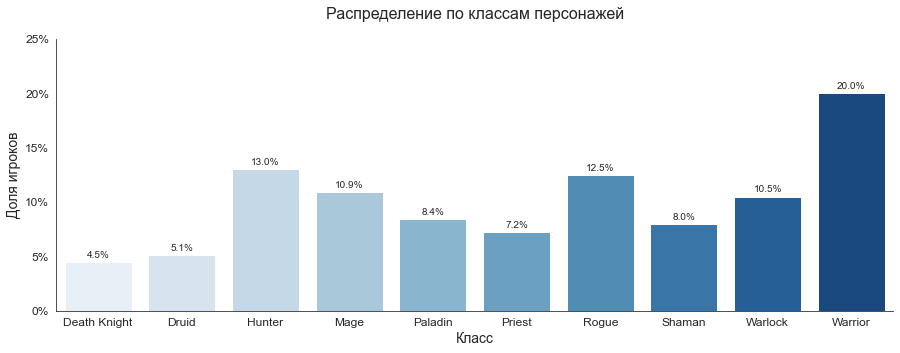

--- 13.657389640808105 seconds ---


In [8]:
start_time = time.time()

class_report = df.pivot_table(index='class', values='player', 
                              aggfunc='nunique').reset_index().rename(columns={'player':'count'})

class_report['%'] = (100 * class_report['count'] / class_report['count'].sum()).round(1)

sns.set_style('white') 
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='class', y='%', data=class_report, palette='Blues')

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height() + 0.4
    ax.annotate('{:.1f}%'.format(class_report.iloc[i, 2]), (x, y), ha='center')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))    
plt.title('Распределение по классам персонажей', fontsize=16, pad=20)    
plt.xlabel('Класс', fontsize=14)
plt.ylabel('Доля игроков', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim([0, 25])
sns.despine()
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Самым популярным классом игрового персонажа является **Warrior**, 20% игроков выбирает данный класс.

Изучим распределение по расам игровых персонажей:

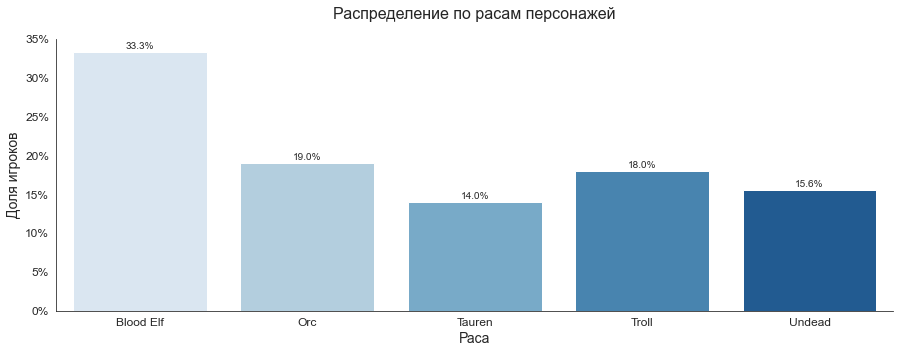

--- 9.264322757720947 seconds ---


In [9]:
start_time = time.time()

race_report = df.pivot_table(index='race', values='player', 
                             aggfunc='nunique').reset_index().rename(columns={'player':'count'})

race_report['%'] = (100 * race_report['count'] / race_report['count'].sum()).round(1)

sns.set_style('white') 
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='race', y='%', data=race_report, palette='Blues')

patches = ax.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width()/2
    y = patches[i].get_height() + 0.4
    ax.annotate('{:.1f}%'.format(race_report.iloc[i, 2]), (x, y), ha='center')
       
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))    
plt.title('Распределение по расам персонажей', fontsize=16, pad=20) 
plt.xlabel('Раса', fontsize=14)
plt.ylabel('Доля игроков', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim([0, 35])
sns.despine()
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Самой популярной расой игрового персонажа является **Blood Elf**, на нее приходится около 33% от всех игровых персонажей.

Изучим совместное распределение по классам и расам игровых персонажей: 

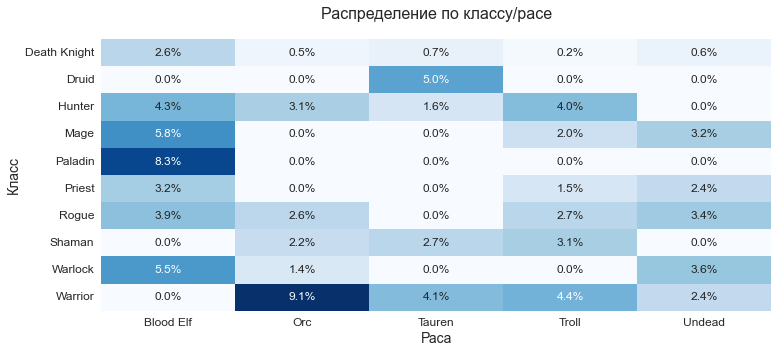

--- 12.593231201171875 seconds ---


In [10]:
start_time = time.time()

class_race_distribution = df.pivot_table(index='class', columns='race', values='player', aggfunc='nunique').fillna(0)
class_race_distribution = class_race_distribution/class_race_distribution.values.sum()

plt.figure(figsize=(12, 5))
sns.heatmap(class_race_distribution, annot=True, annot_kws={'fontsize':12}, fmt='.1%', cmap='Blues', cbar=False)
plt.title('Распределение по классу/расе', fontsize=16, pad=20)
plt.xlabel('Раса', fontsize=14)
plt.ylabel('Класс', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Наибольшая доля игровых персонажей приходится на комбинации **Orc - Warrior** и **Blood Elf - Paladin**, совокупно на них приходится около 17% от всех персонажей.

### ТОП-10 игровых локаций

Рассмотрим ТОП-10 наиболее популярных локаций в игре:

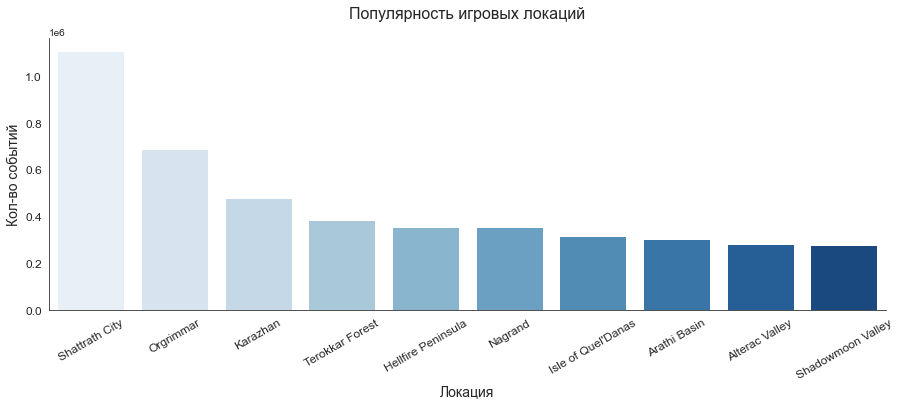

--- 0.8044157028198242 seconds ---


In [11]:
start_time = time.time()

report = df.pivot_table(index='zone', values='player', 
                        aggfunc='count').reset_index().rename(
    columns={'player':'count'}).sort_values(by='count', ascending=False).head(10)

sns.set_style('white') 
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='zone', y='count', data=report, palette='Blues')

plt.title('Популярность игровых локаций', fontsize=16, pad=20) 
plt.xlabel('Локация', fontsize=14)
plt.ylabel('Кол-во событий', fontsize=14)
plt.xticks(rotation=30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Самыми популярными локациями в игре являются: ***Shattrath City***, ***Orgrimmar***	и ***Karazhan***

### Динамика базы игроков

Рассчитаем динамику количества уникальных игроков в день (DAU):

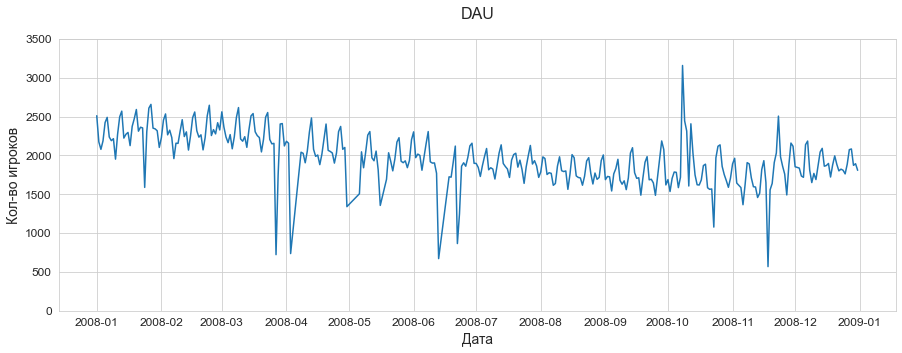

--- 10.335574388504028 seconds ---


In [12]:
start_time = time.time()

report = df.pivot_table(index='date', values='player', aggfunc='nunique').reset_index().rename(columns={'player':'count'})

ax = sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='date', y='count', data=report)   
plt.title('DAU', fontsize=16, pad=20)    
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кол-во игроков', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.set_ylim([0, 3500])
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

В среднем в игру заходило около 2 тыс. уникальных игроков в сутки, есть несколько просадок в апреле и июне, вероятнее всего это связано с техническими проблемами входа на сервер. Также есть пик свыше 3 тыс. активных игроков в октябре, это может быть связано с выходом дополнения ***Wrath of the Lich King*** 13 ноября 2008 г. В динамике DAU наблюдается нисходящий тренд. Колебания DAU связаны с внутринедельной активностью игроков.

Рассчитаем динамику количества уникальных игроков в месяц (MAU):

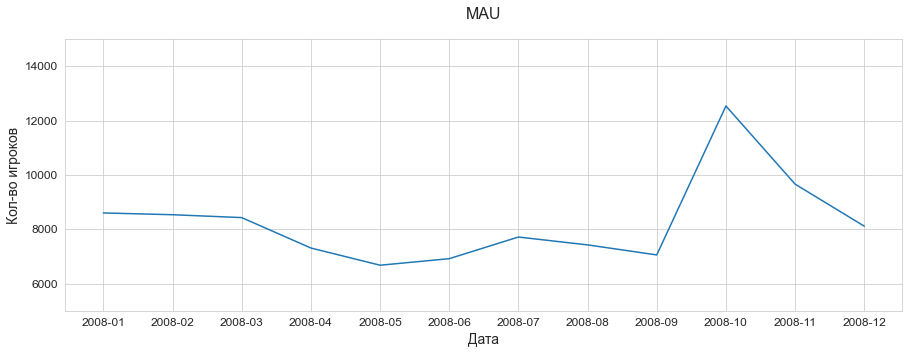

--- 10.765952110290527 seconds ---


In [13]:
start_time = time.time()

report = df.pivot_table(index='month', values='player', aggfunc='nunique').reset_index().rename(columns={'player':'count'})

sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='month', y='count', data=report)  
plt.title('MAU', fontsize=16, pad=20)   
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кол-во игроков', fontsize=14)
ax.set_ylim([5000, 15000])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

В среднем в игру заходило около 8 тыс. уникальных игроков в месяц. Есть пик свыше 12 тыс. игроков, приходящийся на октябрь, что также подтверждает гипотезу о росте популярности игры после выхода дополнения. 

Рассчитаем соотношение DAU/MAU, чтобы понять, какая часть от игроков заходивших в игру в течение месяца осталась дальше в игре:

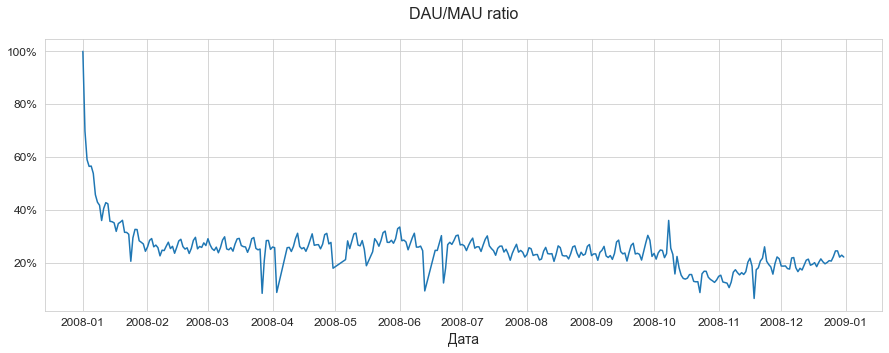

--- 72.53049182891846 seconds ---


In [14]:
start_time = time.time()

report = df.pivot_table(index='date', values='player', aggfunc='nunique').reset_index().rename(columns={'player':'dau'})
horizon_days = 30

def get_mau(max_date):
    end_date = df['date']  
    min_date = max_date - timedelta(days=horizon_days)
    result_raw = df.query('date >= @min_date and date <= @max_date')
    mau = result_raw['player'].nunique()
    return mau

report['mau'] = report['date'].apply(get_mau)
report['dau/mau ratio'] = report['dau']/report['mau']

sns.set_style('whitegrid') 
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='date', y='dau/mau ratio', data=report)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
plt.title('DAU/MAU ratio', fontsize=16, pad=20) 
plt.xlabel('Дата', fontsize=14)
plt.ylabel('', fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Показатель DAU/MAU находится на уровне 30%, что является хорошим показателем для игры, есть небольшая просадка после выхода дополнения в октябре.
Добавим в таблицу данные о дате и месяце первой игровой сессии для проведения когортного анализа:

In [15]:
start_time = time.time()

# дата первой игровой сессии
report = df.groupby('player').agg({'date': 'min'}).reset_index().rename(columns={'date':'first_session'})
df = df.merge(report, on='player', how='left')
df['first_session'] = pd.to_datetime(df['first_session'], format='%Y-%m-%d')
df['generation'] = df['first_session'].dt.strftime('%Y-%m')
df['generation'] = pd.to_datetime(df['generation'], format='%Y-%m')

# вычисляем лайфтайм в днях и в месяцах
df['lifetime_days'] = (df['date'] - df['first_session']).dt.days
df['lifetime_month'] = (df['date'].dt.year - df['generation'].dt.year) * 12 + (df['date'].dt.month - df['generation'].dt.month)
df['generation'] = df['first_session'].dt.strftime('%Y-%m')


# строим таблицу удержания
report = df.pivot_table(index=['generation'], columns='lifetime_month', values='player', aggfunc='nunique')

# вычисляем размеры когорт
cohort_sizes = df.groupby('generation').agg({'player': 'nunique'}).rename(columns={'player': 'cohort_size'})

# объединяем размеры когорт и таблицу удержания
report = cohort_sizes.merge(report, on='generation', how='left')
report = report.div(report['cohort_size'], axis=0).drop(columns=['cohort_size'])

print('--- %s seconds ---' % (time.time() - start_time))

--- 135.01073622703552 seconds ---


Построим тепловую карту удержания игроков по поколениям:

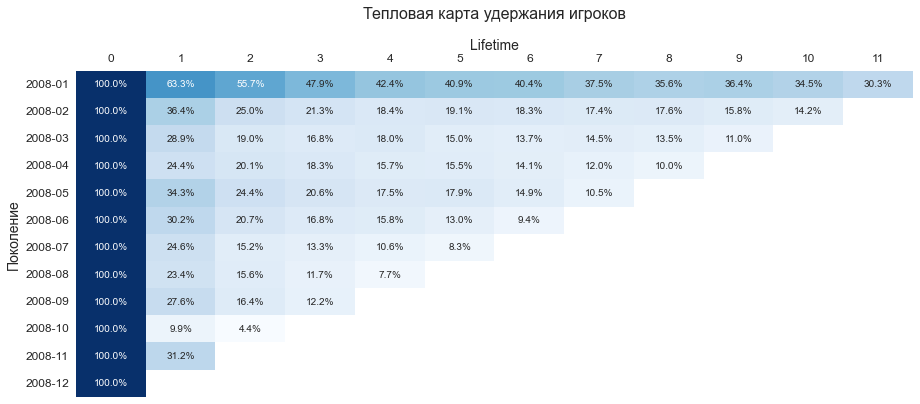

--- 0.33286499977111816 seconds ---


In [16]:
start_time = time.time()

# строим heatmap
plt.figure(figsize=(15, 6))
ax = sns.heatmap(report, annot=True, fmt='.1%', cmap='Blues', cbar=False)
plt.title('Тепловая карта удержания игроков', fontsize=16, pad=20) 
ax.xaxis.set_label_position('top')
plt.tick_params(axis='both', which='major', labelsize=12, labelbottom =False, bottom=False, top=False, labeltop=True)
plt.xlabel('Lifetime', fontsize=14)
plt.ylabel('Поколение', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Лучше всего в плане удержания игроков ведет себя поколение января 2008 г., retention на 12-ый месяц для него составляет 30%, уровень оттока по другим поколениям существенно выше.

Рассчитаем удержание игроков в днях:

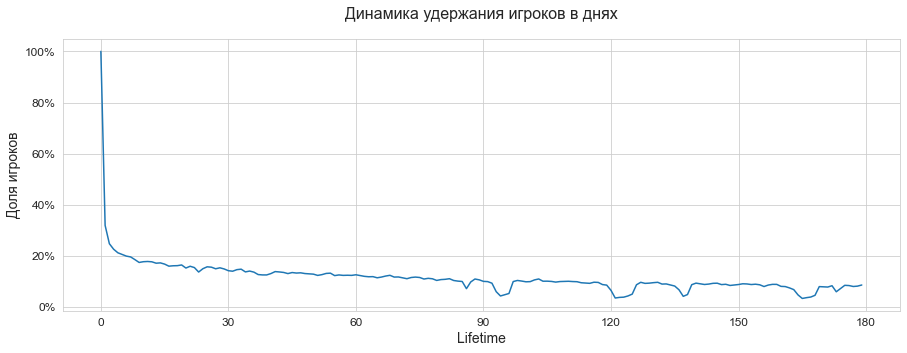

--- 13.586727142333984 seconds ---


In [17]:
start_time = time.time()

# задаём момент и горизонт анализа данных
observation_date = datetime(2008, 12, 31).date()
horizon_days = 180
last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
# исключаем пользователей, пришедших после максимальной даты привлечения
report = df.query('first_session <= @last_suitable_acquisition_date')
cohort_sizes = report.groupby('first_session').agg({'player': 'nunique'}).rename(columns={'player': 'cohort_size'})
report = report.pivot_table(index=['first_session'], columns='lifetime_days', values='player', aggfunc='nunique')
# объединяем размеры когорт и таблицу удержания
report = cohort_sizes.merge(report, on='first_session', how='left').fillna(0)  
# исключаем из результата все lifetime, превышающие горизонт анализа
report = report[['cohort_size'] + list(range(horizon_days))]
# добавим итоговую сумму по строкам
report.loc['Total',:] = report.sum(axis=0)
# делим на размер когорты
report = report.div(report['cohort_size'], axis=0).drop(columns=['cohort_size'])
# транспонируем таблицу
report = report.iloc[-1:].transpose().rename(columns={'Total':'retention'})

sns.set_style('whitegrid')
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x=report.index, y='retention', data=report)   
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
plt.title('Динамика удержания игроков в днях', fontsize=16, pad=20) 
plt.xlabel('Lifetime', fontsize=14)
plt.ylabel('Доля игроков', fontsize=14) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.set_major_locator(MultipleLocator(30))
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Наибольший отток наблюдается в первые дни после начала игры, далее отток стабилизируется. На 180-ый день после начала игры остается лишь около 10% игроков от первоначального количества.

Рассчитаем динамику привлечения новых игроков:

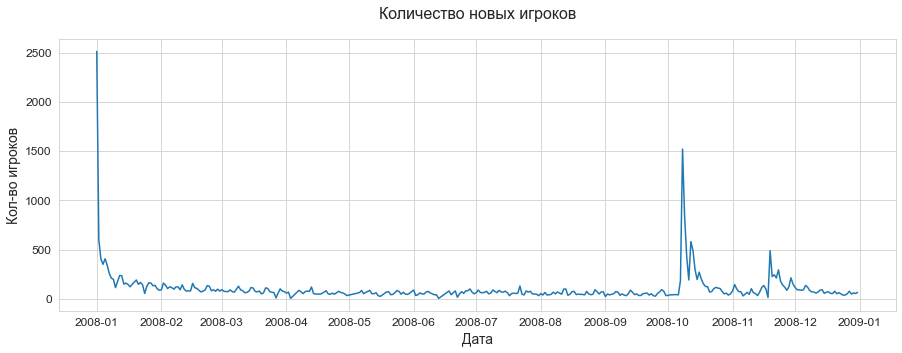

--- 5.448208808898926 seconds ---


In [18]:
start_time = time.time()

report = df.groupby('first_session').agg({'player': 'nunique'}).rename(columns={'player':'count'})

sns.set_style('whitegrid') 
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='first_session', y='count', data=report)
plt.title('Количество новых игроков', fontsize=16, pad=20) 
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кол-во игроков', fontsize=14)   
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

На графике динамики привлечения новых игроков наблюдается 2 пика, первый пик приходится на дату начала наблюдений, а второй на октябрь и связан с выходом дополнения ***Wrath of the Lich King***. Данное дополнение позволило привлечь в игру около 2,5 тыс. новых игроков. В среднем в игру приходило около 100 новых игроков в сутки.

### Затраченное на развитие персонажа время

Проанализируем затраченное на достижение различных игровых уровней время:

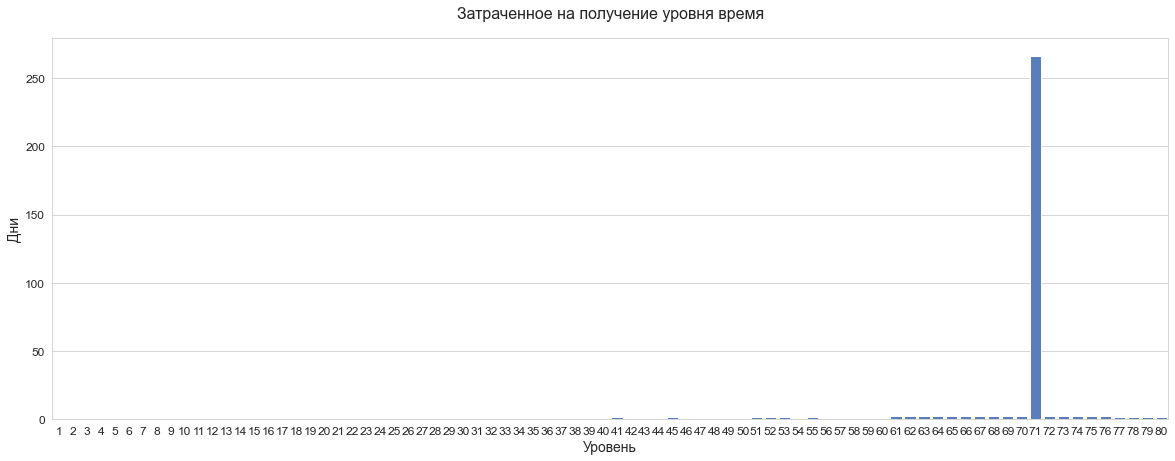

--- 1.8168423175811768 seconds ---


In [19]:
start_time = time.time()

#Находим дату получения уровня
current_level = df.groupby(['player','level']).agg(
    {'timestamp': 'min'}).reset_index().rename(columns={'timestamp':'level_time'})
current_level['previous_level'] = current_level['level'] - 1

previous_level = current_level.copy()
previous_level = previous_level.drop(columns=['previous_level'])

report = current_level.merge(previous_level, left_on=['player','previous_level'],
                             right_on=['player','level'], how='left', suffixes=('_current', '_previous'))
report = report.drop(columns=['level_previous'])
report['leveling_time'] = (report['level_time_current'] - report['level_time_previous'])/pd.to_timedelta(1, unit='D')

sns.set_style('whitegrid') 
plt.figure(figsize=(20, 7))
sns.set_color_codes('muted')
ax = sns.barplot(x='level_current', y='leveling_time', data=report, ci=None, color='b', estimator=median) 
plt.title('Затраченное на получение уровня время', fontsize=16, pad=20)
plt.xlabel('Уровень', fontsize=14)
plt.ylabel('Дни', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Аномально высокое значение времени, затраченного на получение 71 уровня связано с выходом дополнения, в котором максимальный уровень персонажа был увеличен до 80. Разобьем гистограмму на две: для уровеней с 1 по 70 и для уровней свыше 71:

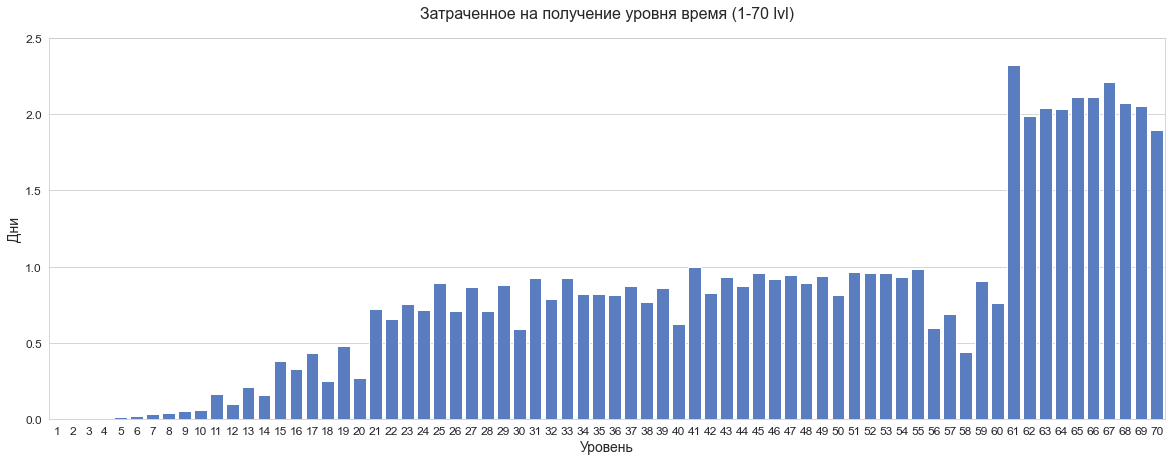

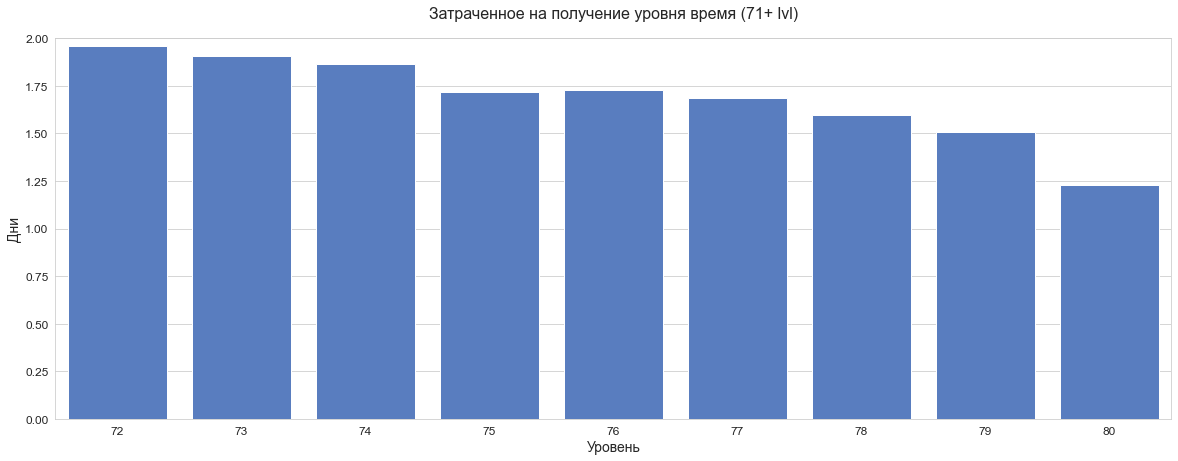

--- 1.132810354232788 seconds ---


In [20]:
start_time = time.time()

sns.set_style('whitegrid') 
plt.figure(figsize=(20, 7))
sns.set_color_codes('muted')
ax = sns.barplot(x='level_current', y='leveling_time', 
                 data=report[report['level_current'] <= 70], ci=None, color='b', estimator=median) 
plt.title('Затраченное на получение уровня время (1-70 lvl)', fontsize=16, pad=20)
plt.xlabel('Уровень', fontsize=14)
plt.ylabel('Дни', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim([0, 2.5])
plt.show()

sns.set_style('whitegrid') 
plt.figure(figsize=(20, 7))
sns.set_color_codes('muted')
ax = sns.barplot(x='level_current', y='leveling_time', 
                 data=report[report['level_current'] > 71], ci=None, color='b', estimator=median) 
plt.title('Затраченное на получение уровня время (71+ lvl)', fontsize=16, pad=20)
plt.xlabel('Уровень', fontsize=14)
plt.ylabel('Дни', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylim([0, 2.0])
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

На данных гистограммах можно оценить динамику изменения времени, затраченного на получение каждого нового уровня, которое в свою очередь характеризует эволюцию сложности игрового процесса. Можно заметить, что начиная с 61 уровня время, затраченное на достижение следующего уровня возросло вдвое и составило около 2-ух дней. Для получения каждого следующего уровня начиная с уровня 25 и по 55 в среднем требовалось чуть менее суток.

Построим гистограмму накопленного времени, затрачаенного на достижение уровней: 

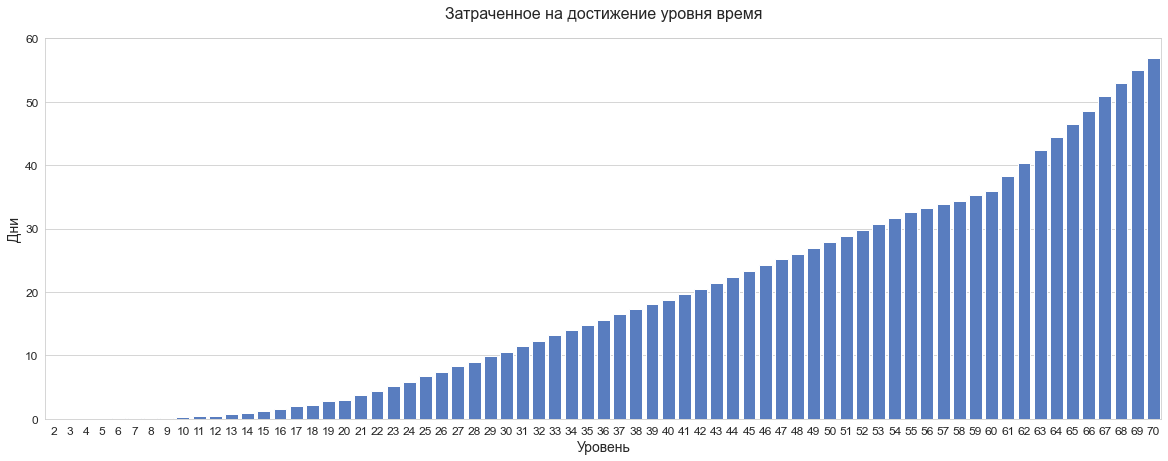

--- 0.9537460803985596 seconds ---


In [21]:
start_time = time.time()

report = report.pivot_table(index='level_current', values='leveling_time', aggfunc='median').reset_index()
report['leveling_time_cumulative'] = report['leveling_time'].cumsum(axis=0)

sns.set_style('whitegrid') 
plt.figure(figsize=(20, 7))
sns.set_color_codes('muted')
ax = sns.barplot(x='level_current', 
                 y='leveling_time_cumulative', 
                 data=report[report['level_current'] <= 70], ci=None, color='b', estimator=median) 
plt.title('Затраченное на достижение уровня время', fontsize=16, pad=20)
plt.xlabel('Уровень', fontsize=14)
plt.ylabel('Дни', fontsize=14)
ax.set_ylim([0, 60])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

В среднем на достижение 70 уровня требуется около 60 дней.

Оценим распределение времени, затраченного на достижение 70 уровня:

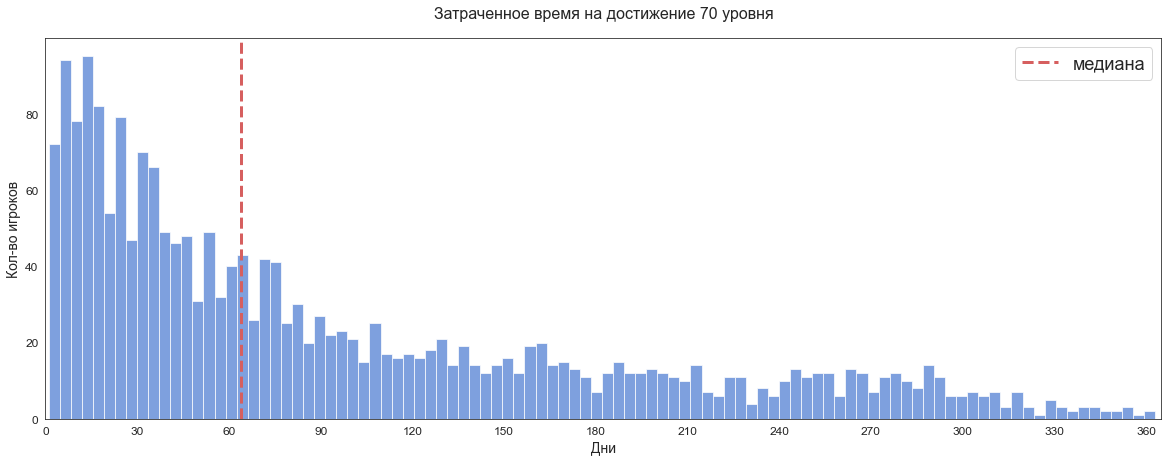

--- 1.2111012935638428 seconds ---


In [22]:
start_time = time.time()

report = df[df['level'] == 70].groupby('player').agg(
    {'date': 'min', 'first_session':'min'}).reset_index().rename(columns={'date':'70_lvl_date'})
report['time_to_get_70_lvl'] = (report['70_lvl_date'] - report['first_session']).dt.days.astype(float)
report = report[report['time_to_get_70_lvl'] != 0]

sns.set_style('white') 
plt.figure(figsize=(20, 7))
sns.set_color_codes('muted')
ax = sns.distplot(report['time_to_get_70_lvl'], bins=100, color='b', kde=False, hist_kws={'alpha':0.7})
plt.axvline(x=report['time_to_get_70_lvl'].median(), linewidth=3, color='r', linestyle='--', label='медиана', alpha=1)
plt.title('Затраченное время на достижение 70 уровня', fontsize=16, pad=20)
plt.xlabel('Дни', fontsize=14)
plt.ylabel('Кол-во игроков', fontsize=14)
ax.set_xlim([0, 365])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.set_major_locator(MultipleLocator(30))
plt.legend()
plt.legend(prop={'size':18})
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Медиана приходится на диапазон 60-65 дней. 

### Игровая активность

Оценим распределение игровой активности по времени суток и дням недели:

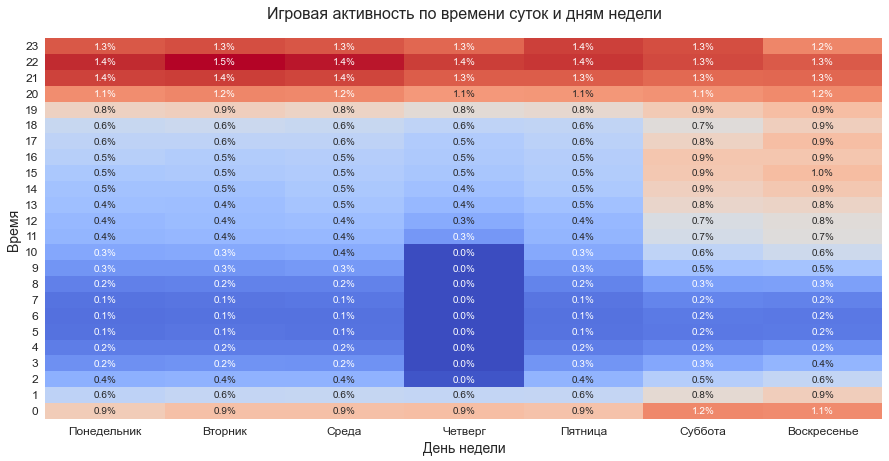

--- 0.9998090267181396 seconds ---


In [23]:
start_time = time.time()

report = df.pivot_table(index='hour', columns='weekday', values='player', aggfunc='count').rename(columns=
                                                        {1:'Понедельник', 
                                                         2:'Вторник', 
                                                         3:'Среда', 
                                                         4:'Четверг', 
                                                         5:'Пятница', 
                                                         6:'Суббота', 
                                                         7:'Воскресенье'}).sort_values(by='hour', ascending=False).fillna(0)

report = report.div(report.values.sum()) 

plt.figure(figsize=(15, 7))
sns.heatmap(report, annot=True, fmt='.1%', cmap='coolwarm', cbar=False)
plt.yticks(rotation=0) 
plt.title('Игровая активность по времени суток и дням недели', fontsize=16, pad=20)
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Время', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Пик игровой активности приходится на вечернее время с 19:00 по 00:00.

Оценим игровую активность в разрезе дней недели:

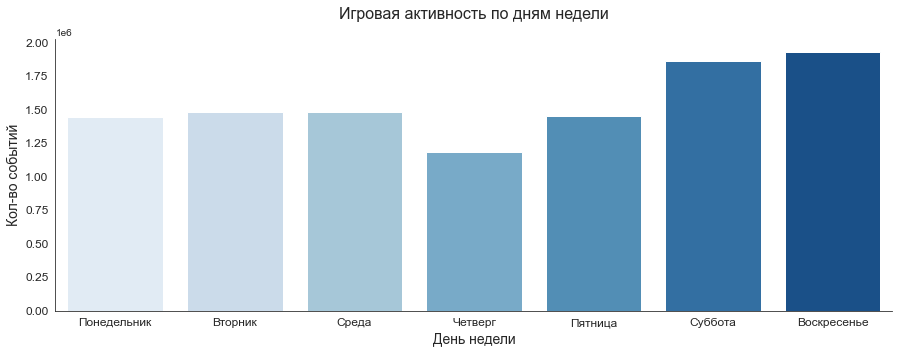

--- 0.31296372413635254 seconds ---


In [24]:
start_time = time.time()

report = df.pivot_table(index='weekday', values='player', 
                        aggfunc='count').reset_index().rename(columns={'player':'count'}).sort_values(by='weekday')

sns.set_style('white') 
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='weekday', y='count', data=report, palette='Blues')

plt.title('Игровая активность по дням недели', fontsize=16, pad=20) 
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Кол-во событий', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.set_xticklabels(['Понедельник','Вторник','Среда','Четверг','Пятница','Суббота','Воскресенье'])
sns.despine()
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Самая высокая активность наблюдается в субботу и в воскресенье, а наименьшая в четверг.

Построим график игровой активности в зависимости от времени суток:

C:\Users\babae\AppData\Local\Temp/ipykernel_12408/4117819088.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


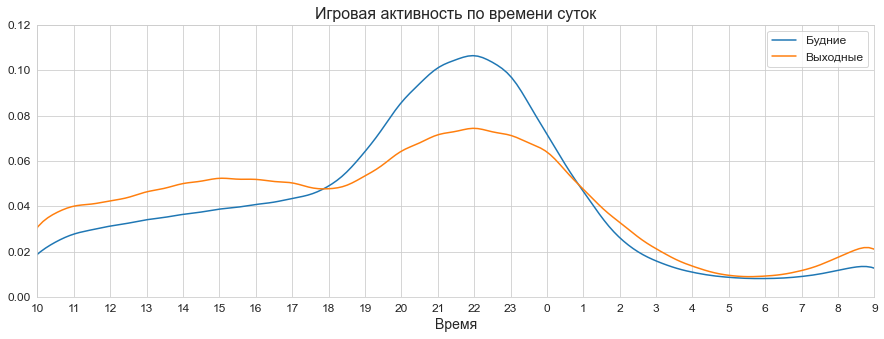

--- 25.910146474838257 seconds ---


In [25]:
start_time = time.time()

# словарь для корректного ранжирования времени суток
hour_map = {10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 
            18:9, 19:10, 20:11, 21:12, 22:13, 23:14, 0:15, 1:16, 
            2:17, 3:18, 4:19, 5:20, 6:21, 7:22, 8:23, 9:24}

df['hour'] = df['hour'].map(hour_map)

sns.set_style('whitegrid') 
plt.figure(figsize=(15, 5))
ax = sns.distplot(df[df['weekday_type'] == 'Будние']['hour'], hist=False, kde_kws={'bw':0.12}, label='Будние')
ax = sns.distplot(df[df['weekday_type'] == 'Выходные']['hour'], hist=False, kde_kws={'bw':0.1}, label='Выходные')

ax.set_xlim([1, 24])
ax.set_ylim([0, 0.12])
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.title('Игровая активность по времени суток', fontsize=16)    
plt.xlabel('Время', fontsize=14)
plt.ylabel('', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
labels = [9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9]
ax.set_xticklabels(labels)
plt.legend()
plt.legend(prop={'size':12})
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Пик игровой активности приходится на 22:00, при том это справедливо и для будних и для выходных дней, но в выходные дни пик менее выражен и игровая активность более равномерно распределена в течение суток.

Оценим игровую активность в разрезе времен года:

C:\Users\babae\anaconda3\lib\site-packages\july\helpers.py:31: RuntimeWarning: invalid value encountered in multiply
  grid = np.nan * grid if dtype == "float64" else grid


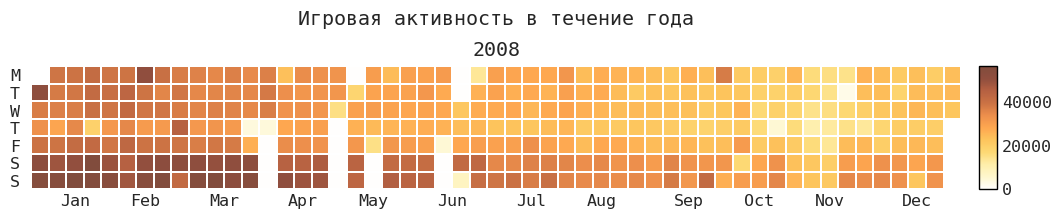

--- 0.37384963035583496 seconds ---


In [26]:
start_time = time.time()

report = df.pivot_table(index='date', values='player', aggfunc='count').reset_index().rename(columns={'player':'count'})
july.heatmap(data=report['count'], dates=report['date'], cmap='golden', colorbar=True,  
             title='Игровая активность в течение года')
plt.show()

print('--- %s seconds ---' % (time.time() - start_time))

Наиболее высокая игровая активность наблюдалась в I квартале, а наименьшая в IV.

## Общий вывод

На основании проведенного анализа можно выделить следующие рекомендации для улучшения игрового опыта и снижения оттока:
- Наблюдается выраженная предпочтительность игроков в отношении выбора расы и класса персонажа, возможно это связано с несбалансированностью показателей рас и классов. Необходимо более детально проанализировать игровой баланс и характеристики персонажей.
- Скорость развития персонажа нелинейна, при достижении 60 уровня сложность прокачки персонажа возрастает. Необходимо провести проверку гипотезы о влиянии сложности развития персонажа на отток и скорректировать кривую сложности.
- Наибольший отток наблюдается в первые дни игры, необходимо сконцентрироваться на механиках удержания игроков в самом начале их игрового опыта.